In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [4]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [2]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [112]:
def regress(option, df, plot=True):
    # creates a regression graph plotted against actual data from certain QA metrics
    # option: takes str value of either snr_total or tsnr to model against
    # df    : takes pandas DataFrame with data
    
    # checks parameters passed in
    if option != 'snr_total' and option != 'tsnr':
        return "Option must be snr_total or tsnr"
    
    elif type(df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    # preparing sin and cos curves to add to the model
    n = len(df)
    date = str(df.iat[0,0])
    values = [np.sin(np.pi*i/(26)) for i in range(n)]
    values2 = [np.cos(np.pi*i/(26)) for i in range(n)]
    dates = [dt.datetime(int(date[:4]), int(date[4:6]), int(date[6:])) + dt.timedelta(days = i*7) for i in range(n)]

    sin = pd.DataFrame(values)
    sin.columns = ['seasonal (sin)']
    
    cos = pd.DataFrame(values2)
    cos.columns = ['seasonal (cos)']
    
    df = df.join(sin)
    df = df.join(cos)
    
    # Converting date to a format that can be parsed by statsmodels API
    df['Date'] = pd.to_datetime(df['Date'], format="%Y%m%d")
    df['Date2'] = df['Date'].map(pd.datetime.toordinal)
    
    # Assigning independent and dependent variables
    list = []
    
    for item in df.std().iteritems():
        if item[0] != 'Date' and item[0] != option and item[1] != 0:
            list.append(item[0])
    
    X = df[list]
    X = sm.add_constant(X)
    y = df[option]
    
    # modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)

    ################ CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    params = []
    
    # get p-values
    for key, value in dict(model.pvalues).items():
        if value < 0.05:
            # identify statistically insignificant variables in df
            params.append(key)
    
    # set statistically insignificant variables to 0
    if len(params) != 0:
        for param in params:
            
            dup_df = df.copy(True) # prepare for mods
            
            X2 = dup_df[list]
            X2 = sm.add_constant(X2)
            y2 = dup_df[option]

            model2 = sm.OLS(y2, X2).fit()
            
            for key, value in model2.params.items():
                if key != param:
                    model2.params[key] = 0
            
            print(model2.summary())
            predictions2 = model2.predict(X2)
            prediction = predictions2.to_frame()
            prediction.columns = ['model2']
            df2 = df.join(prediction)

            # plotting the graph
            plt.figure(figsize=(15, 6))

            ax = sns.lineplot(x="Date", y=option, data=df2, color="#ff9933")
            ax_txrefamp = plt.twinx()
            sns.lineplot(x="Date", y="model2", data=df2, color="r", ax=ax)
            ax.legend([option, 'predicted value'])

            plt.plot(dates,values, color='#A9A9A9', label="seasonal (sin)")
            plt.plot(dates,values2, color='#A9A9A9', label="seasonal (cos)")
            plt.legend(['seasonal (sin)', 'seasonal (cos)'], loc='upper left')
    else:
        print("No statistically significant variables")
    
    ################ END CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    
    if not plot:
        return model
    # converting the above predictions to a format that can be plotted
    prediction = predictions.to_frame()
    prediction.columns = ['model']
    df2 = df.join(prediction)

    # plotting the graph
    plt.figure(figsize=(15, 6))

    ax = sns.lineplot(x="Date", y=option, data=df2, color="#ff9933")
    ax_txrefamp = plt.twinx()
    sns.lineplot(x="Date", y="model", data=df2, color="r", ax=ax)
    ax.legend([option, 'predicted value'])

    plt.plot(dates,values, color='#A9A9A9', label="seasonal (sin)")
    plt.plot(dates,values2, color='#A9A9A9', label="seasonal (cos)")
    plt.legend(['seasonal (sin)', 'seasonal (cos)'], loc='upper left')
    
    # giving additional data
    print(model.summary())
    
    if 'Shim1' and 'Shim2' and 'Shim3' and 'Shim4' and 'Shim5' and 'Shim6' and 'Shim7' and 'Shim8' in list:
        print("Shim F-test: ")
        print(model.f_test("Shim1 = Shim2 = Shim3 = Shim4 = Shim5 = Shim6 = Shim7 = Shim8 = 0"))
    
    if 'IOPD1' and 'IOPD2' and 'IOPD3' and 'IOPD4' and 'IOPD5' and 'IOPD6' in list:
        print("IOPD F-test: ")
        print(model.f_test("IOPD1 = IOPD2 = IOPD3 = IOPD4 = IOPD5 = IOPD6 = 0"))
    
    print("Seasonal F-test:")
    print(model.f_test("seasonal (sin) = seasonal (cos) = 0"))
    return model

All Conversion Softwares are the same: True


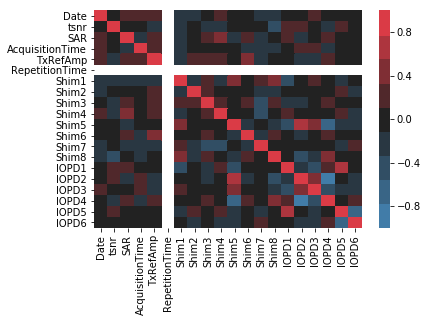

In [7]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


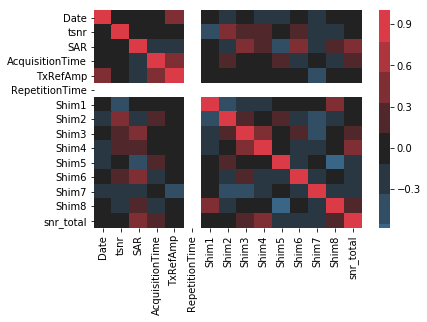

In [8]:
analyses('../data/extractions/p2_BOLD_snr.csv')

In [86]:
files = pd.read_csv('../data/extractions/p2_BOLD.csv')
df = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df_shim = pd.DataFrame(files,columns=['Date', 'tsnr', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df_iopd = pd.DataFrame(files,columns=['Date', 'tsnr', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df_tx = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp'])
# df_AT = pd.DataFrame(files,columns=['Date', 'tsnr', 'AcquisitionTime'])
# df_SAR = pd.DataFrame(files,columns=['Date', 'tsnr', 'SAR'])
# df_RT = pd.DataFrame(files,columns=['Date', 'tsnr', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                     -71.742
Model:                            OLS   Adj. R-squared:                -92.826
Method:                 Least Squares   F-statistic:                    -3.403
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               1.00
Time:                        16:38:15   Log-Likelihood:                -628.08
No. Observations:                  90   AIC:                             1298.
Df Residuals:                      69   BIC:                             1351.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const                    0   1.67e+05     

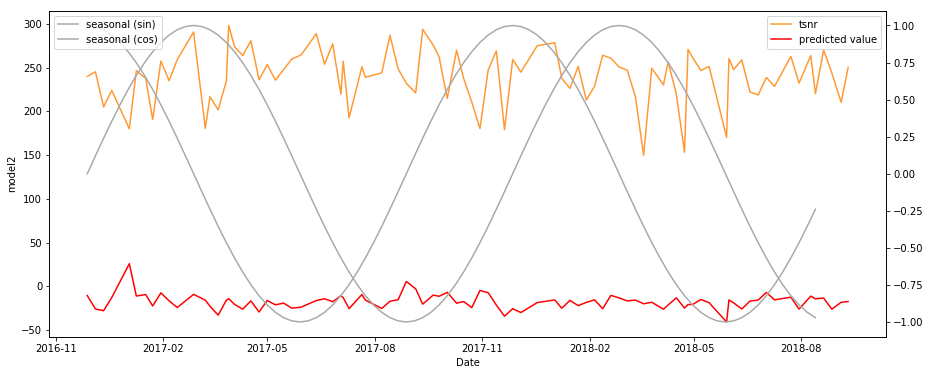

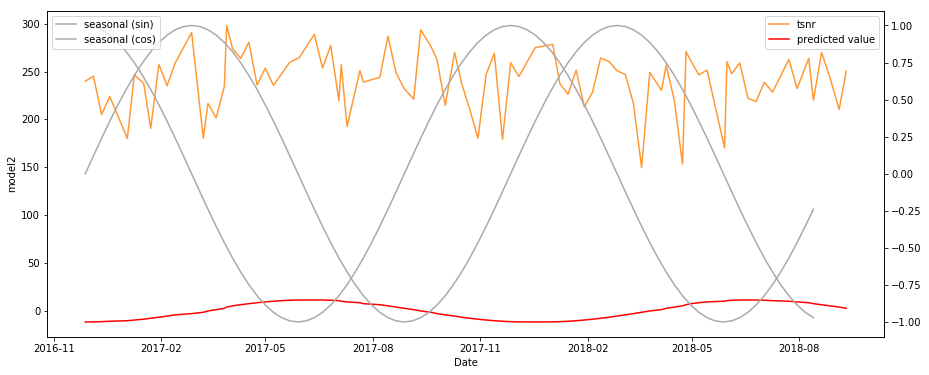

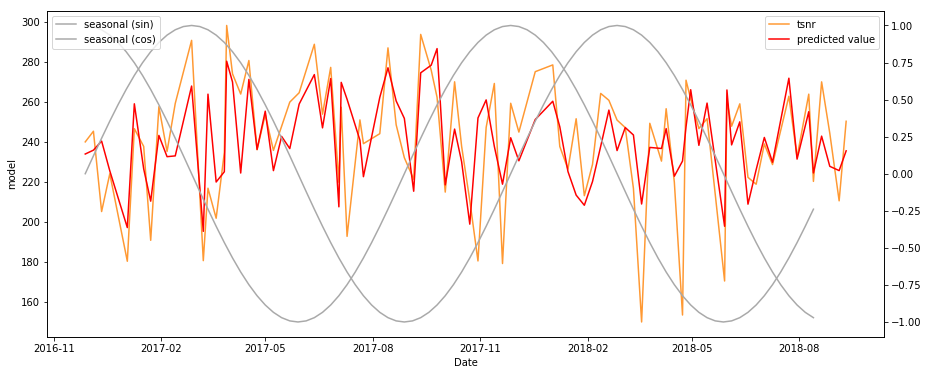

In [113]:
regress('tsnr', df)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.047
Date:                Thu, 04 Apr 2019   Prob (F-statistic):             0.0345
Time:                        14:27:56   Log-Likelihood:                -423.76
No. Observations:                  90   AIC:                             871.5
Df Residuals:                      78   BIC:                             901.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.572e+04   1.51e+04      1.

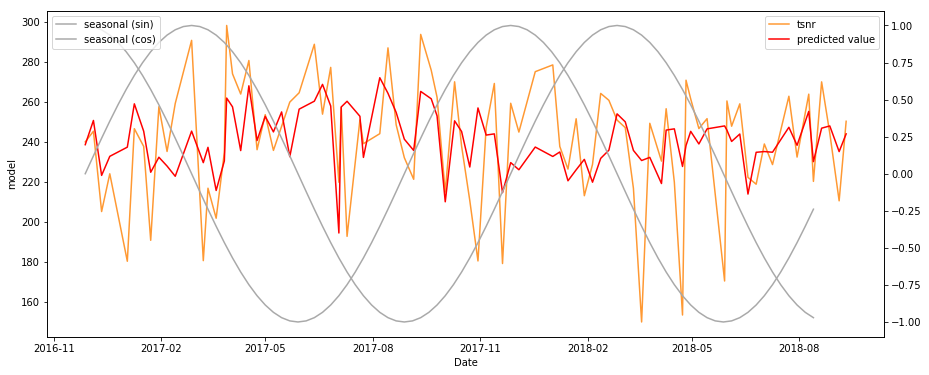

In [20]:
regress('tsnr', df_shim)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     3.692
Date:                Thu, 04 Apr 2019   Prob (F-statistic):           0.000659
Time:                        14:32:16   Log-Likelihood:                -419.54
No. Observations:                  90   AIC:                             859.1
Df Residuals:                      80   BIC:                             884.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.622e+04   1.23e+04      2.

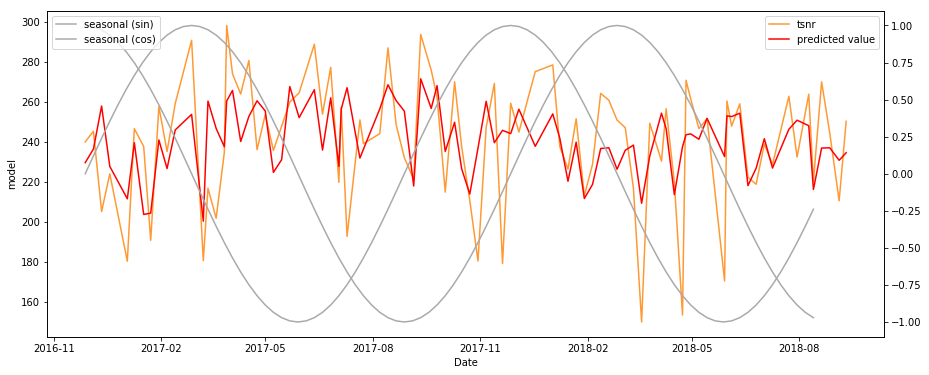

In [22]:
regress('tsnr', df_iopd)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.403
Date:                Thu, 04 Apr 2019   Prob (F-statistic):              0.240
Time:                        14:39:04   Log-Likelihood:                -432.30
No. Observations:                  90   AIC:                             874.6
Df Residuals:                      85   BIC:                             887.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           8095.6055   1.37e+04      0.

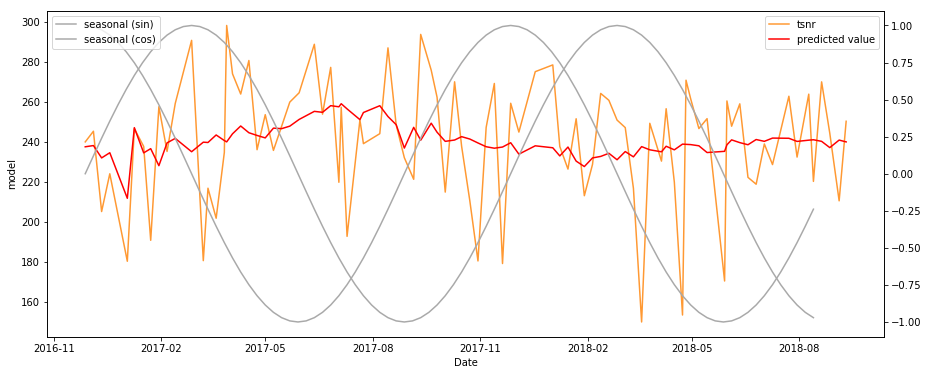

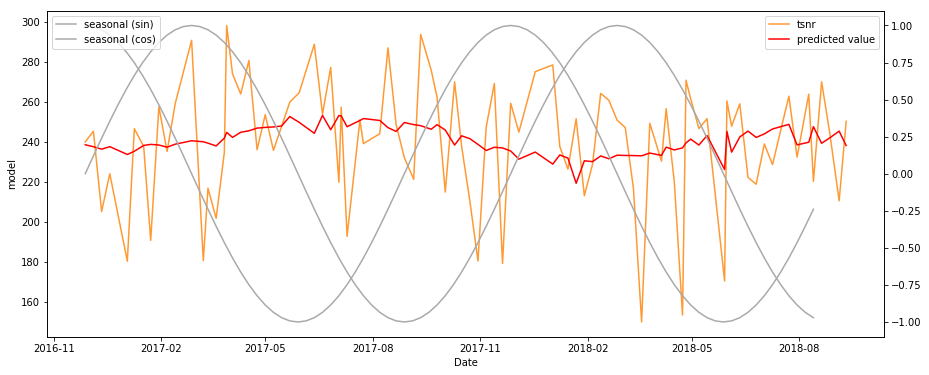

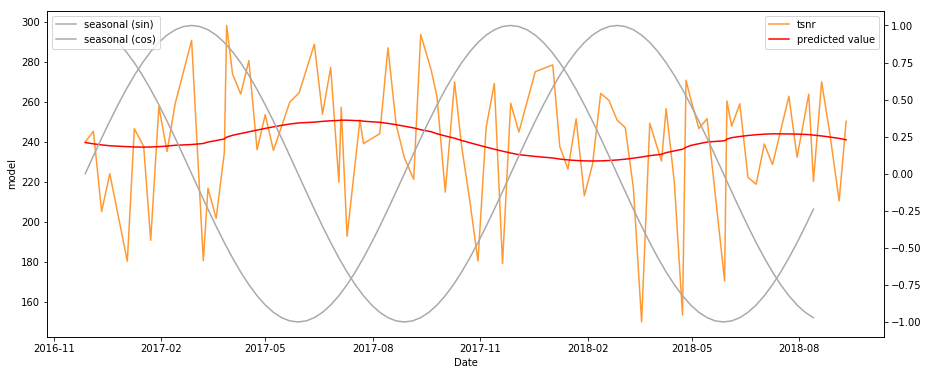

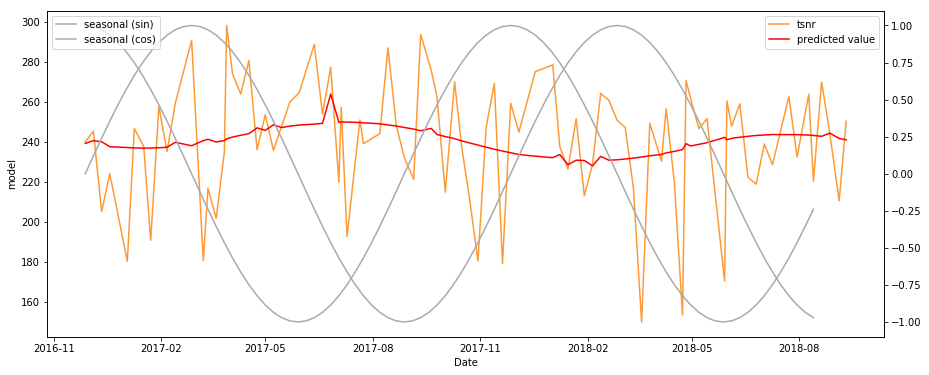

In [24]:
regress('tsnr', df_tx)
regress('tsnr', df_AT)
regress('tsnr', df_RT)
regress('tsnr', df_SAR)

In [114]:
# p2Xs4X35mm_BOLD.csv
files2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv')
df2 = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_shim = pd.DataFrame(files2,columns=['Date', 'tsnr', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df2_iopd = pd.DataFrame(files2,columns=['Date', 'tsnr', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_tx = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp'])
# df2_AT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'AcquisitionTime'])
# df2_SAR = pd.DataFrame(files2,columns=['Date', 'tsnr', 'SAR'])
# df2_RT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                     -84.714
Model:                            OLS   Adj. R-squared:               -111.184
Method:                 Least Squares   F-statistic:                    -3.200
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               1.00
Time:                        16:42:11   Log-Likelihood:                -622.26
No. Observations:                  90   AIC:                             1289.
Df Residuals:                      68   BIC:                             1344.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const                    0   1.82e+05     

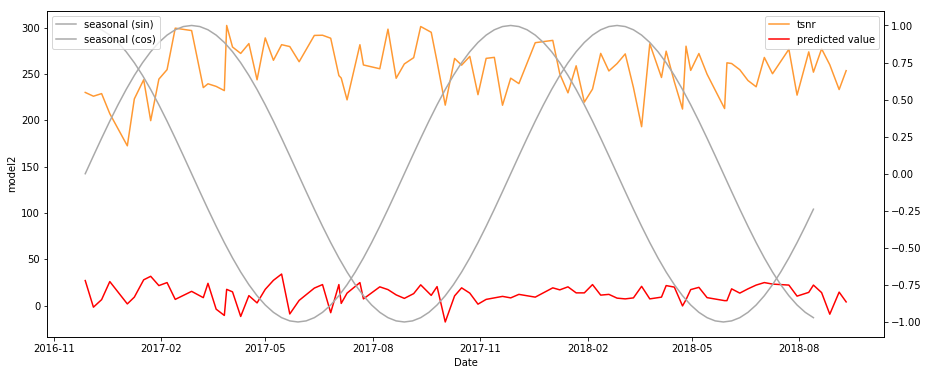

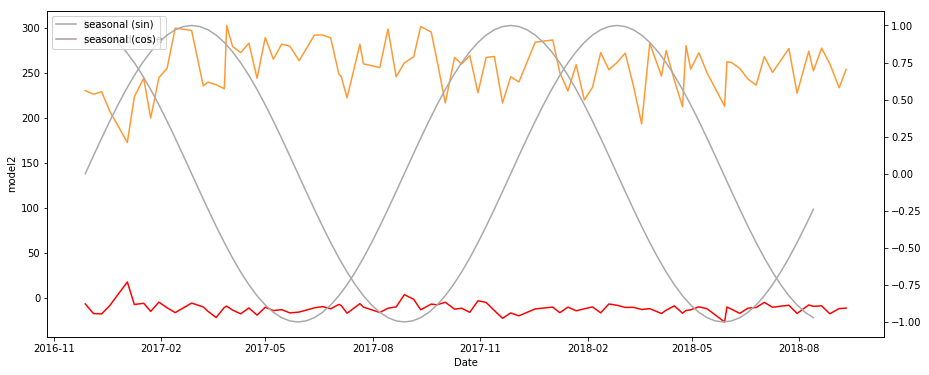

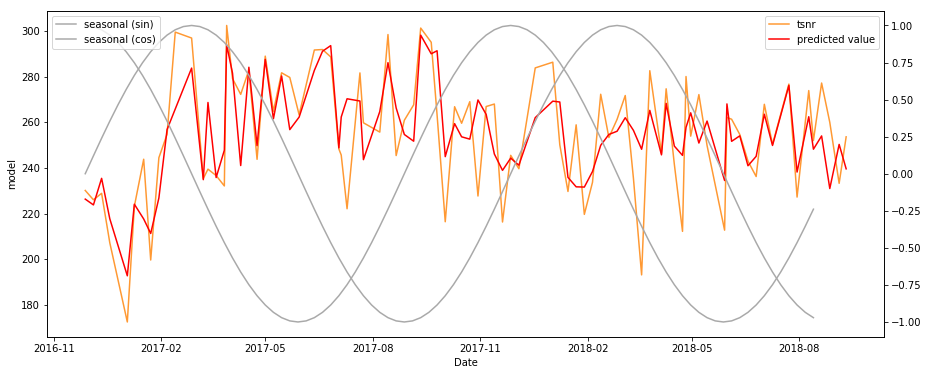

In [115]:
regress('tsnr', df2)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     3.601
Date:                Thu, 04 Apr 2019   Prob (F-statistic):           0.000391
Time:                        14:46:57   Log-Likelihood:                -403.49
No. Observations:                  90   AIC:                             831.0
Df Residuals:                      78   BIC:                             861.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4520.0213    1.2e+04      0.

                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     3.294
Date:                Thu, 04 Apr 2019   Prob (F-statistic):             0.0147
Time:                        14:46:58   Log-Likelihood:                -415.48
No. Observations:                  90   AIC:                             841.0
Df Residuals:                      85   BIC:                             853.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4971.1138   1.11e+04     

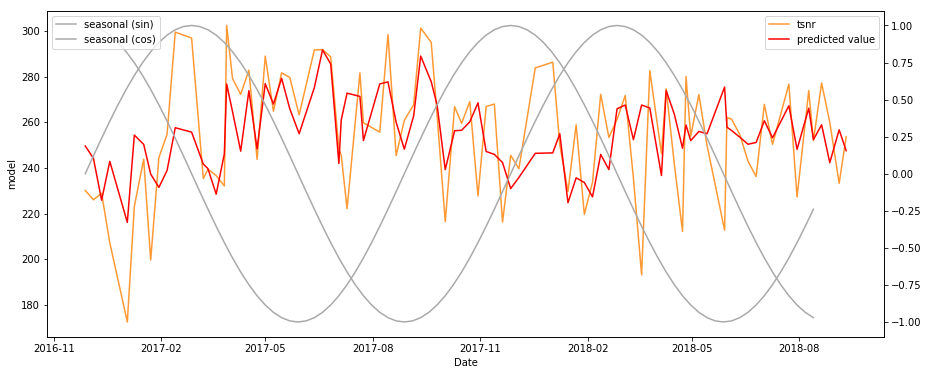

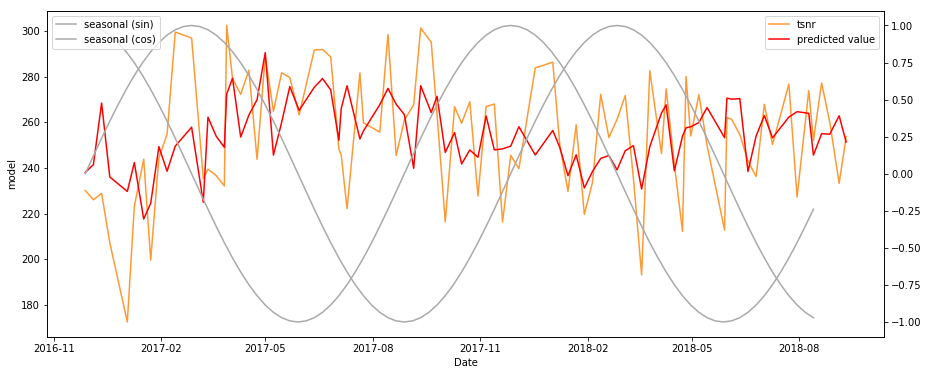

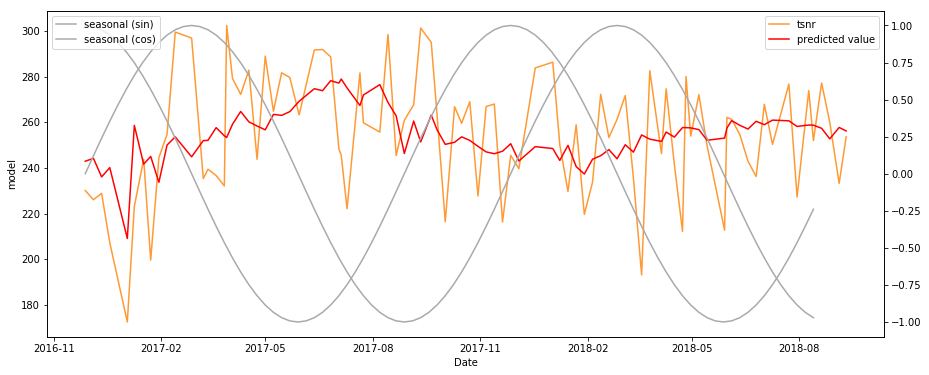

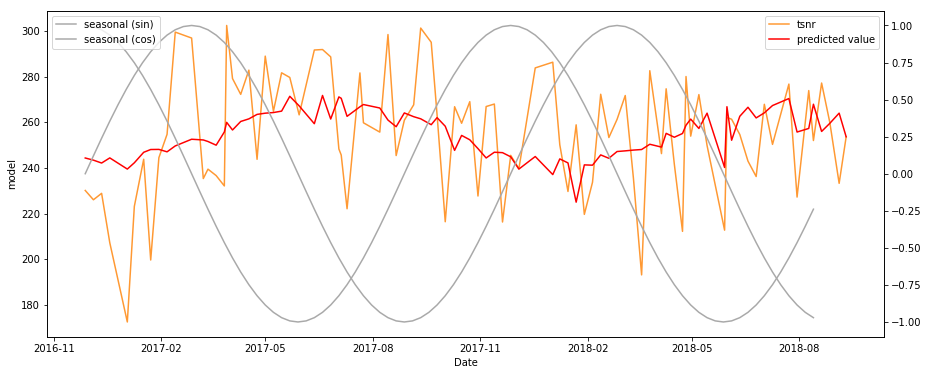

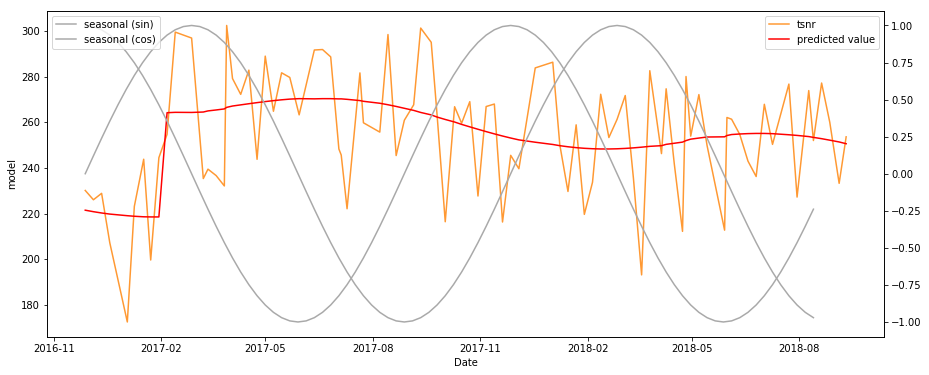

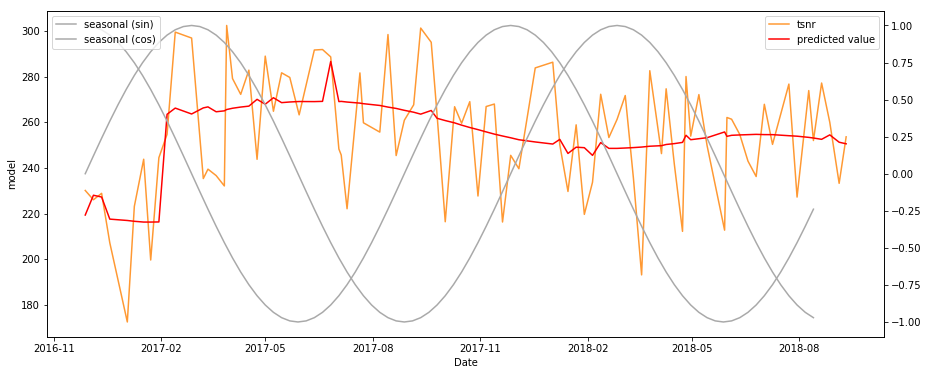

In [32]:
regress('tsnr', df2_shim)
regress('tsnr', df2_iopd)
regress('tsnr', df2_tx)
regress('tsnr', df2_AT)
regress('tsnr', df2_RT)
regress('tsnr', df2_SAR)

In [35]:
files3 = pd.read_csv('../data/extractions/anat.csv')
df3 = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2', 'IOPD3', 'IOPD4',
                                'IOPD5', 'IOPD6'])
df3_shim = pd.DataFrame(files3,columns=['Date', 'snr_total', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8'])
df3_iopd = pd.DataFrame(files3,columns=['Date', 'snr_total', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
df3_tx = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp'])
df3_AT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'AcquisitionTime'])
df3_SAR = pd.DataFrame(files3,columns=['Date', 'snr_total', 'SAR'])
df3_RT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'RepetitionTime'])

                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     3.194
Date:                Thu, 04 Apr 2019   Prob (F-statistic):            0.00455
Time:                        14:15:54   Log-Likelihood:                -86.977
No. Observations:                  44   AIC:                             200.0
Df Residuals:                      31   BIC:                             223.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
TxRefAmp            0.0557      0.194     

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


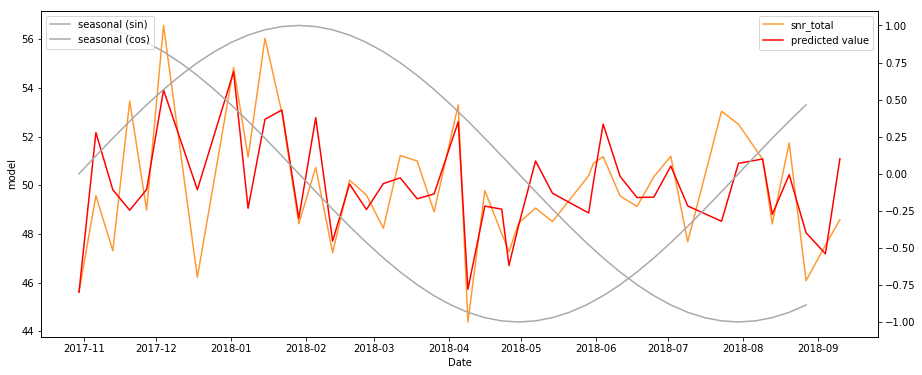

In [14]:
regress('snr_total', df3)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.3686
Date:                Thu, 04 Apr 2019   Prob (F-statistic):              0.776
Time:                        14:48:23   Log-Likelihood:                -104.08
No. Observations:                  44   AIC:                             216.2
Df Residuals:                      40   BIC:                             223.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1517.3720   7320.189     -0.

                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.397
Date:                Thu, 04 Apr 2019   Prob (F-statistic):              0.253
Time:                        14:48:24   Log-Likelihood:                -101.74
No. Observations:                  44   AIC:                             213.5
Df Residuals:                      39   BIC:                             222.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1535.3446   7028.459     -0.

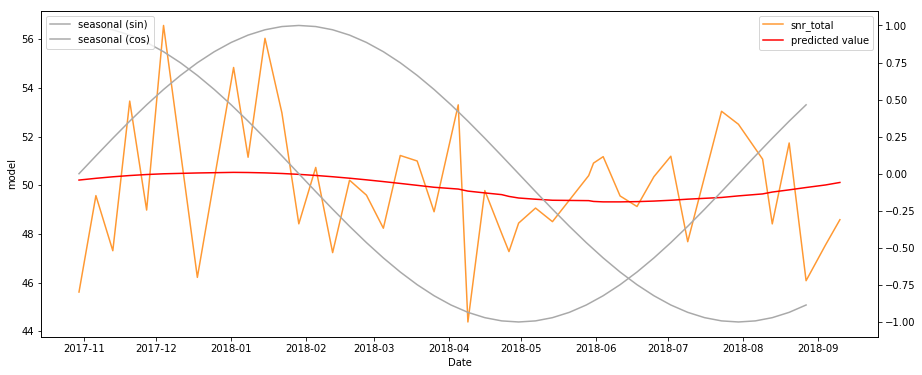

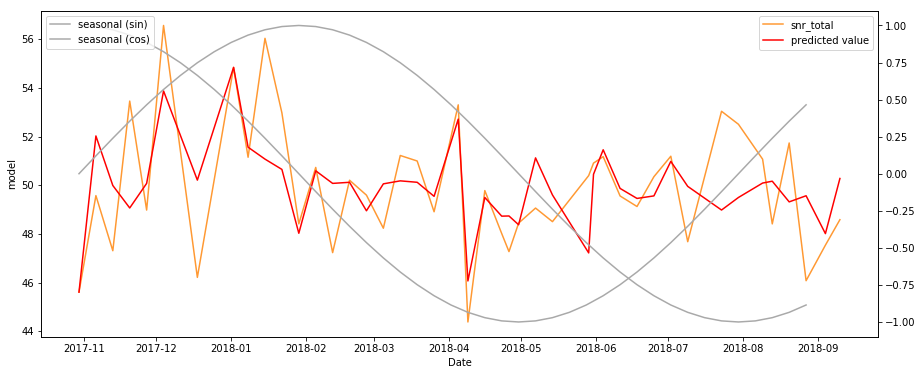

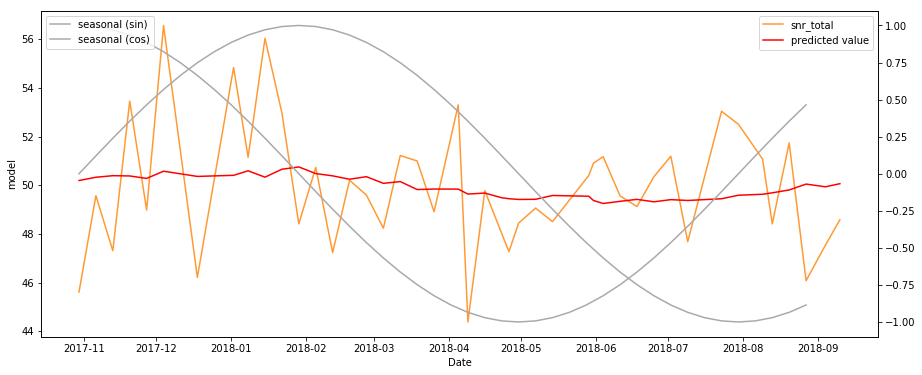

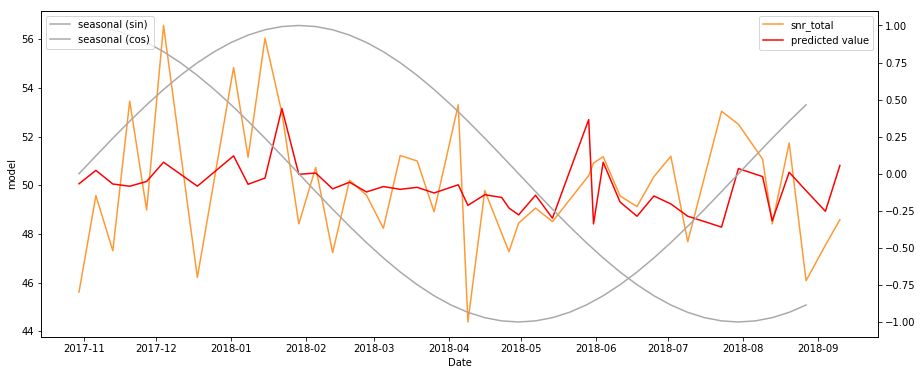

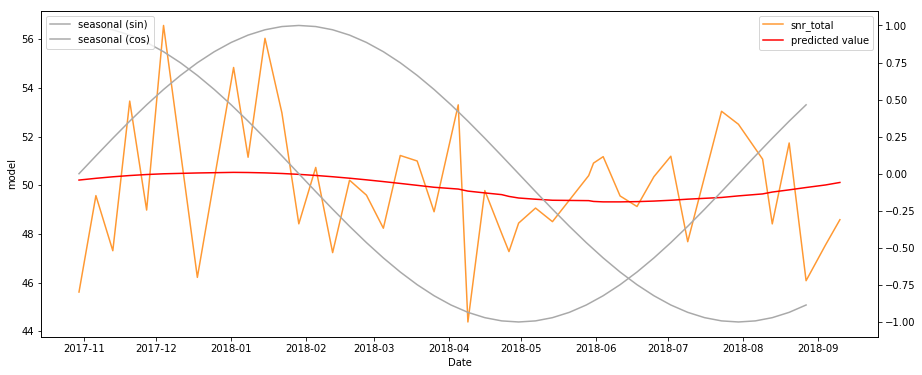

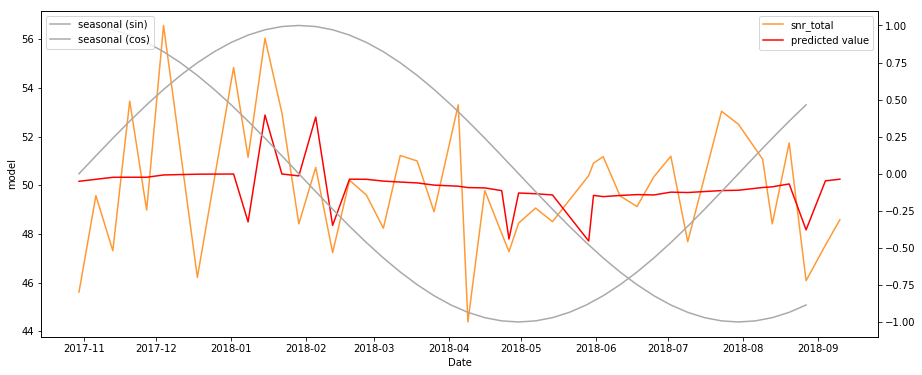

In [36]:
regress('snr_total', df3_shim)
regress('snr_total', df3_iopd)
regress('snr_total', df3_tx)
regress('snr_total', df3_AT)
regress('snr_total', df3_RT)
regress('snr_total', df3_SAR)